Import Packages

In [31]:
# feel free to add more
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

Read Data

In [32]:
df = pd.read_csv('C:/Data/garments_worker_productivity.csv')

In [33]:
# Check which variable contains missing values
print(df.isnull().sum())

date                       0
quarter                    0
department                 0
day                        0
team                       0
targeted_productivity      0
smv                        0
wip                      506
over_time                  0
incentive                  0
idle_time                  0
idle_men                   0
no_of_style_change         0
no_of_workers              0
actual_productivity        0
dtype: int64


In [34]:
# Since about 50% of the observations in wip are missing, we may consider delete this variable, but feel free to use other treatments.
df = df.drop(['wip'], axis = 1)
# Since workday and quarter area already captured in different features, we can probably delete date
df = df.drop(['date'], axis = 1)
# The variable idle_men seems to contain little information that is not already captured by idle time
df = df.drop(['idle_men'], axis = 1)
# Idle time is mostly 0 - thus dichotomizing it makes sense
df['idle_time'] = df['idle_time'].apply(lambda x: 1 if x > 0 else x)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   quarter                1197 non-null   object 
 1   department             1197 non-null   object 
 2   day                    1197 non-null   object 
 3   team                   1197 non-null   int64  
 4   targeted_productivity  1197 non-null   float64
 5   smv                    1197 non-null   float64
 6   over_time              1197 non-null   int64  
 7   incentive              1197 non-null   int64  
 8   idle_time              1197 non-null   float64
 9   no_of_style_change     1197 non-null   int64  
 10  no_of_workers          1197 non-null   float64
 11  actual_productivity    1197 non-null   float64
dtypes: float64(5), int64(4), object(3)
memory usage: 112.3+ KB


In [36]:
#I made team a category (even though its a number), same with targets and changes
cat_cols = ['quarter', 'department', 'day', 'team', 'targeted_productivity', 'no_of_style_change']
num_cols = ['smv', 'over_time', 'incentive', 'no_of_workers']
#One hot encoding, dropping the first category
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)
#Standardizing all features (not the labels)
scaler= StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

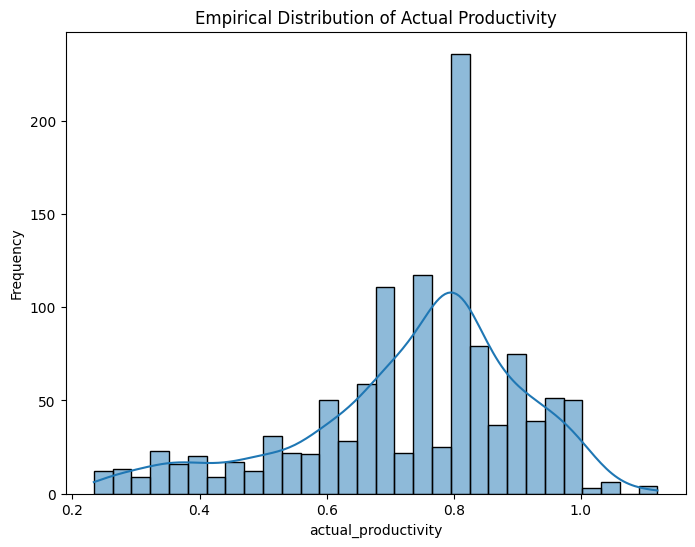

In [37]:
# What is our dependent variable/label?
response_variable = df['actual_productivity']

# Plot the empirical distribution
plt.figure(figsize = (8, 6))
sns.histplot(response_variable, kde = True, bins = 30)  # kde = True plots the kernel density estimate
plt.title('Empirical Distribution of Actual Productivity')
plt.xlabel('actual_productivity')
plt.ylabel('Frequency')
plt.show()

Assuming we are doing a regressing task for now, can you try identify any features thay may contribute to an employee's actual productivity?

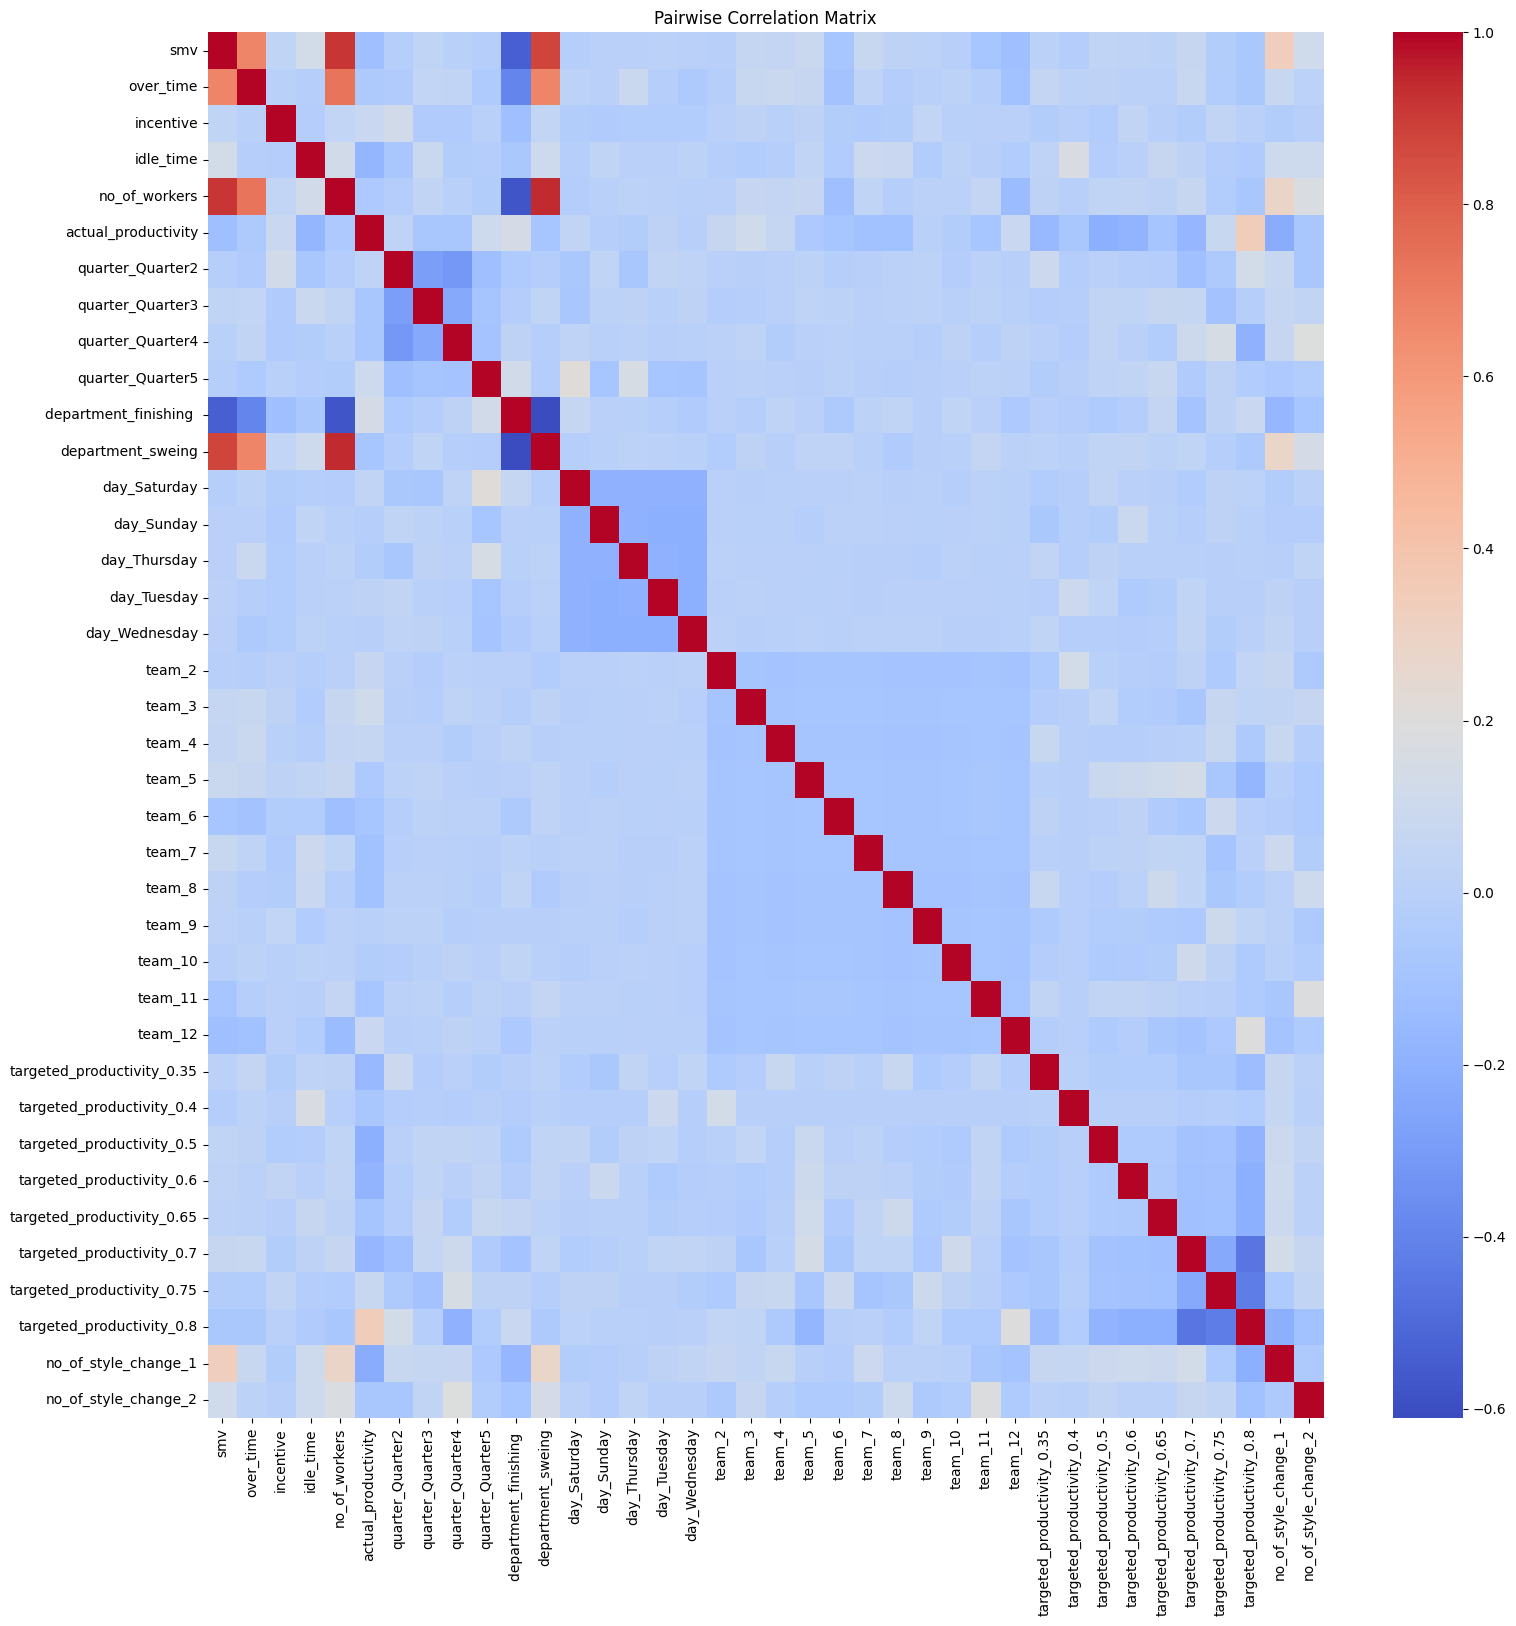

In [38]:
# A grid plot for pairwise correlation may be helpful 

# Compute the correlation matrix
corr_matrix = df.corr()

# Plot the correlation matrix
plt.figure(figsize = (18, 18))
sns.heatmap(corr_matrix, cmap = 'coolwarm', annot=False)
plt.title('Pairwise Correlation Matrix')
plt.show()

# What features are highly correlated to the response?
# what another important signal you see from the correlation matrix?

In [39]:
#We will need this function later; it creates a random vector of n 0/1s with m 1s

def random_binary_vector(n, m):
    if m > n:
        raise ValueError("m cannot be greater than n")
    
    # Create a vector with m ones and n - m zeros
    vector = np.array([1] * m + [0] * (n - m))
    
    # Shuffle the vector
    np.random.shuffle(vector)
    
    return vector

In [40]:
#Define Xs and ys
X = df.drop('actual_productivity', axis=1)
y = df['actual_productivity']

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.30, random_state = 42)

MAE: 0.08706341140000001
MSE: 0.025711880678394076
RMSE: 0.16034924595517772
R-squared: 0.13972735274848402


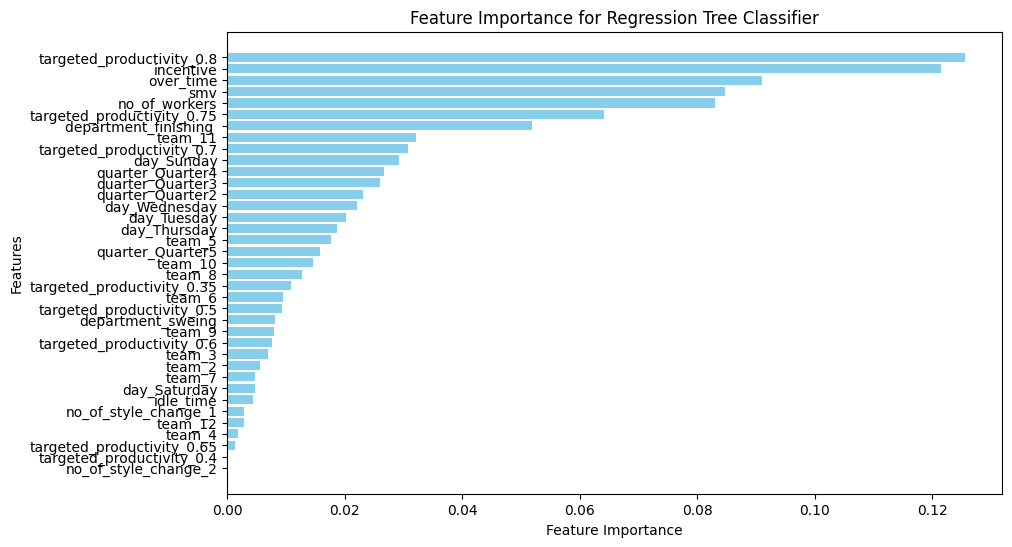

In [42]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Train a regression tree
reg_tree = DecisionTreeRegressor(random_state=42)
reg_tree.fit(X_train, y_train)

y_pred = reg_tree.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R-squared: {r2}")

# Extract feature importance
feature_importance = reg_tree.feature_importances_

def plot_feature_importance(importances, feature_names):
    # Convert feature importance into a pandas DataFrame for better handling
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })

    # Sort by importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.xlabel('Feature Importance')
    plt.ylabel('Features')
    plt.title('Feature Importance for Regression Tree Classifier')
    plt.gca().invert_yaxis()
    plt.show()

# Step 7: Plot feature importance using actual feature names from the DataFrame
plot_feature_importance(feature_importance, X.columns)

In [43]:
hired_A = (y_pred > 70/120).astype(int)
profit_A = hired_A * (120 * y_test - 70)

In [44]:
print(f"Percentage Placed Type A: {sum(hired_A)/len(hired_A):.2f}%")
print(f"Total Profit for Type A: {sum(profit_A):.2f}")

Percentage Placed Type A: 0.82%
Total Profit for Type A: 6792.97


In [45]:
random_A = random_binary_vector(len(hired_A), sum(hired_A))
profit_random_A = random_A * (120 * y_test - 70)
print(f"Total Profit for Random A: {sum(profit_random_A):.2f}")

Total Profit for Random A: 5364.16


In [46]:
y = df['actual_productivity'].apply(lambda x: 1 if x > 0.80 else 0)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.30, random_state = 42)

Accuracy: 0.76
Confusion Matrix:
[[148  45]
 [ 41 126]]
Area Under the ROC Curve (AUC): 0.83


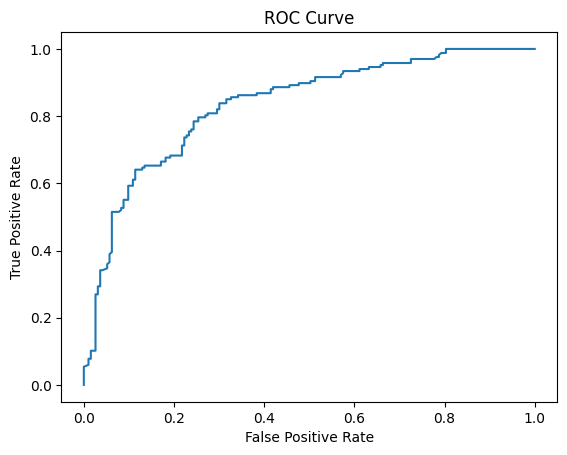

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, roc_auc_score

# Train a Logit
clf_logit = LogisticRegression(penalty='l1', solver='liblinear', C=0.5)
clf_logit.fit(X_train, y_train)

y_pred = clf_logit.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

y_proba = clf_logit.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

auc = roc_auc_score(y_test, y_proba)
print(f"Area Under the ROC Curve (AUC): {auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

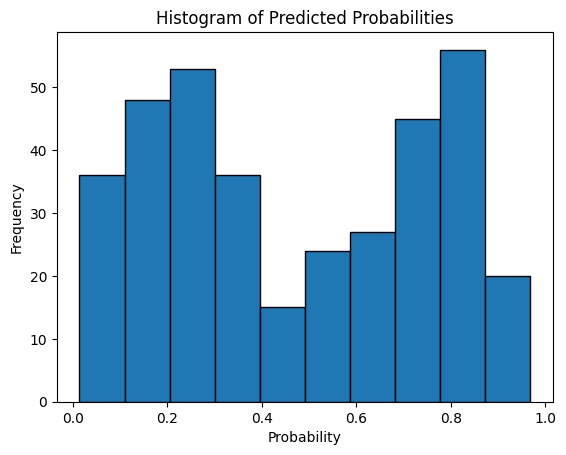

In [49]:
# Plotting the histogram
plt.hist(y_proba, bins=10, edgecolor='black')

# Adding labels and title
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Probabilities')

# Show plot
plt.show()

In [50]:
hired_B = (y_proba > 70/200).astype(int)
profit_B = hired_B * (200 * y_test - 70)

In [51]:
print(f"Percentage Placed Type B: {sum(hired_B)/len(hired_B):.2f}%")
print(f"Total Profit for Type B: {sum(profit_B)}")

Percentage Placed Type B: 0.57%
Total Profit for Type B: 14120


In [52]:
random_B = random_binary_vector(len(hired_B), sum(hired_B))
profit_random_B = random_B * (200 * y_test - 70)
print(f"Total Profit for Random B: {sum(profit_random_B)}")

Total Profit for Random B: 5320
